<a href="https://colab.research.google.com/github/dellaanima/NLP_GoingDeeper/blob/main/10/Project_Translator_Transformer_SentencePiece_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean - English Translation Transformer Model



# SentencePiece EOS 이거 제외하고 다시

**Table of Contents**

## Rubric

# Import Modules

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00


In [1]:
import re
import os
import io
import random   #학습 데이터 섞기
import tarfile
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm   #학습과정 시각화
from tqdm import tqdm_notebook   #학습과정 시각화
import tensorflow as tf
import sentencepiece as spm


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

import pickle
import seaborn

In [2]:
plt.rcParams['font.family'] = 'NanumBarunGothic'  # 나눔바른고딕 폰트 사용

# About the Dataset

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

이전 프로젝트에서 사용한 데이터와 동일한 데이터 이기 때문에, 08/Project_Translator_Seq2Seq+Attention_Original.ipynb 에서 수행한 전처리 과정을 동일하게 수행하여, Pickle 파일로 가져와 바로 사용함.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#  전처리 끝낸, pickle 파일 (DataFrame) 불러오기
pickle_file_path = '/content/drive/MyDrive/Colab Notebooks/dataset.pkl'
with open(pickle_file_path, 'rb') as file:
    dataset = pickle.load(file)

print("Loaded DataFrame:")
display(dataset)

Loaded DataFrame:


,kor,eng
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,<sos> much of personal computing is about can ...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<sos> so a mention a few weeks ago about a rec...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"<sos> like all optical mice , but it also does..."
3,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어...",<sos> uses gyroscopic sensors to control the c...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,<sos> intelligence officials have revealed a s...
...,...,...
94118,우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 총...,<sos> we are hoping to seize material evidence...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다 .,"<sos> on monday , police secured statements fr..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다 .,<sos> but the lack of material evidence is mak...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다 .,<sos> kim and his son both deny the allegation...


SentencePiece : sp_tokenize 함수에서 sentencepice 패키지 내장 함수로 양끝 토큰 처리 할거여서, 위에 수행 했던 작업 제거함.

In [ ]:
# eng 칼럼의 모든 row에 대해 <sos>와 <eos> 제거
dataset['eng'] = dataset['eng'].str.replace('<sos>', '').str.replace('<eos>', '')

In [7]:
dataset

,kor,eng
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?,much of personal computing is about can you t...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a recharge...
2,그러나 이것은 또한 책상도 필요로 하지 않는다 .,"like all optical mice , but it also doesn t n..."
3,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어...",uses gyroscopic sensors to control the cursor...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,intelligence officials have revealed a spate ...
...,...,...
94118,우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 총...,we are hoping to seize material evidence to p...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다 .,"on monday , police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다 .,but the lack of material evidence is making i...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다 .,kim and his son both deny the allegations .


### Tokenize the Dataset


https://github.com/keras-team/keras-docs-ko/blob/master/sources/preprocessing/text.md

- tokenize 함수는, Encoder, Decoder Dataset 에 맞게 토큰화를 시키고, 모델의 입력이 될  tensor 와 tokenizer 를 return 한다.

[tf.keras.preprocessing.text.Tokenizer(...) 객체]
- 객체 생성 후,  
- tokenizer.fit_on_texts(corpus_input)메서드로 tokenizer 객체에 corpus_input 주입하여 tokenizer를 학습시키는 과정을 수행한다.
- fit_on_text(text) 일때, text 는 List, Pandas Seires 도 가능
- 단어들을 토큰화하며 각 단어에 고유한 정수 인덱스를 부여합니다. (가장 빈도가 높은 것부터, 낮은 인덱스 부여)  

- 한국어는 형태소 단위로 쪼개진 데이터를 입력으로, 영어는 그냥 원래 Corpus 를 입력으로


현재 디렉토리에 dataset 폴더를 만들어둬야한다.


In [8]:
# train the sentencepiece tokenizer
def train_sp_tokenizer(corpus, model_type='unigram', vocab_size=30000, lang="ko"):
    input_file = f'./dataset/{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))

    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)

    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set

    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s '
    input_argument += '--model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'

    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)

    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')

    return tokenizer


#Get tokenizer & tensor
def sp_tokenize(data, vocab_size, langue):
    tokenizer = train_sp_tokenizer(data, 'unigram', vocab_size, langue)
    if langue == "en":
        tokenizer.set_encode_extra_options("bos:eos")

    tensor = data.apply(tokenizer.EncodeAsIds).tolist()
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=None
    )
    return tensor, tokenizer

In [25]:
enc_tensor, enc_tokenizer = sp_tokenize(dataset["kor"], 30000, "ko")
dec_tensor, dec_tokenizer  = sp_tokenize(dataset["eng"], 25000, "en")

<br>

# 모델 설계 및 학습


## 모델 설계 : Transformer


### Positional Encoding Layer  & Multihead Attention Layer

In [26]:
#Positional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table



#MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights



#Position-wise Feed-Forward Network
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out



#Mask 레이어
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask



### Encoder & Decoder Layer



In [11]:
#Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn



#Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn


### Encoder & Decoder

In [31]:
#Encoder
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns



#Decoder
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


### Transformer Model



In [32]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))


    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns



# 모델 학습

### LearningRateScheduler

In [33]:

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.cast(step, tf.float32) ** -0.5
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


<br>

#### 학습 하이퍼파리미터 설정



<br>

#### 모델 학습 함수 설정

In [34]:
# 손실 함수
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


In [35]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [36]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

# 여기서 부터 시작


# 학습 과정 출력 함수 정의

In [37]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [38]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        seaborn.heatmap(
            data,
            square=True,
            vmin=0.0, vmax=1.0,
            cbar=False, ax=ax,
            xticklabels=x, yticklabels=y
        )

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print(f"[Encoder Layer(=Self Attention) {layer + 1} ]")
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()


    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print(f"[Decoder Self Layer {layer + 1} ]")
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()


        print(f"[Decoder Layer(Context Vector By Decoder Input) {layer + 1}]")
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()


# 번역 생성 함수
def evaluate(
    sentence,
    model,
    src_tokenizer, tgt_tokenizer,
    enc_maxlen, dec_maxlen,
):

    def idx_to_text(idx):
        return tgt_tokenizer.decode_ids(idx)

    sentence = preprocess_sentence(sentence)


    pieces = src_tokenizer.encode_as_pieces(sentence)
    _input = [src_tokenizer.encode_as_ids(sentence)]

    sos_idx = tgt_tokenizer.bos_id()
    eos_idx = tgt_tokenizer.eos_id()

    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = idx_to_text(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = idx_to_text(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(
    sentence,
    model,
    src_tokenizer, tgt_tokenizer,
    enc_maxlen, dec_maxlen,
    plot_attention=False,
):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(
        sentence,
        model,
        src_tokenizer, tgt_tokenizer,
        enc_maxlen, dec_maxlen,
    )

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
    else:
        print("Korean Sentence:".rjust(18), sentence)
        print("English Sentence:".rjust(18), result, end="\n\n")


In [39]:
examples = [
    "아버지가 방에 들어가신다.",
    "저는 지금 공부를 하고 있어요.",
    "비가 올 수 있으니 꼭 우산을 챙기세요.",
    "컴퓨터가 고장났어요.",
    "저희 내일 저녁 7시에 만날래요?",
    "현재 날씨는 28도 입니다.",
    "당신을 정말 사랑해요.",
    "저는 음악을 들으면서 산책하는 것을 좋아해요.",
    "최근에 재밌게 본 영화가 있나요?",
    "여행 가고 싶어요."
]


In [40]:
def train_model(enc_tensor, dec_tensor, enc_tokenizer, dec_tokenizer):
    enc_maxlen, dec_maxlen = enc_tensor.shape[-1], dec_tensor.shape[-1]

    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm_notebook(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_tensor[idx:idx+BATCH_SIZE],
                dec_tensor[idx:idx+BATCH_SIZE],
                transformer,
                optimizer
            )

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.3f' % (total_loss.numpy() / (batch + 1)))

        if (epoch+1) % 5 == 0:
            print(f"[EPOCH {epoch}]")
            for example in examples:
                translate(
                    example,
                    transformer,
                    enc_tokenizer, dec_tokenizer,
                    enc_maxlen, dec_maxlen,
                    plot_attention=False
                )

        if (epoch+1) == EPOCHS:
            translate(
                examples[0],
                transformer,
                enc_tokenizer, dec_tokenizer,
                enc_maxlen, dec_maxlen,
                plot_attention=True
            )

## 모델 생성 및 학습


In [41]:
transformer = Transformer(
    n_layers=2,
    d_model=256,
    n_heads=8,
    d_ff=128,
    dropout=0.2,
    pos_len=200,
    shared=True,
    src_vocab_size=30000, tgt_vocab_size=25000
)

#### 모델 학습 + 모델 성능 확인

In [42]:

BATCH_SIZE = 64
EPOCHS = 10

<ipython-input-40-f80adb630dd9>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

[EPOCH 4]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: father is a father of the room .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i ve been going to be a school .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: the day of the day , the weather service said .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: computer games were fared .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: we re going to get rid of this evening ?

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: now , the weather is now at 8 .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: you know , you know , you know .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: music , music music , music music

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: recent recent recently , the latest film is a recent story ?

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: you ll want to get to get to get to get to you .



  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

[EPOCH 9]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: fathers are the father of a room .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i m a job for you live .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: the possibility of the economy , which may have been repeated that it was the same time this year , may be a good thing .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: a serious error was a patient at the heart .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: we re going to get tomorrow evening ?

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: two weathers are two of 8 .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: you know , you love you .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: i m s music to do i m a good thing

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: it s recently attracting people in recently ?

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: i m to take some of you .

[E

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


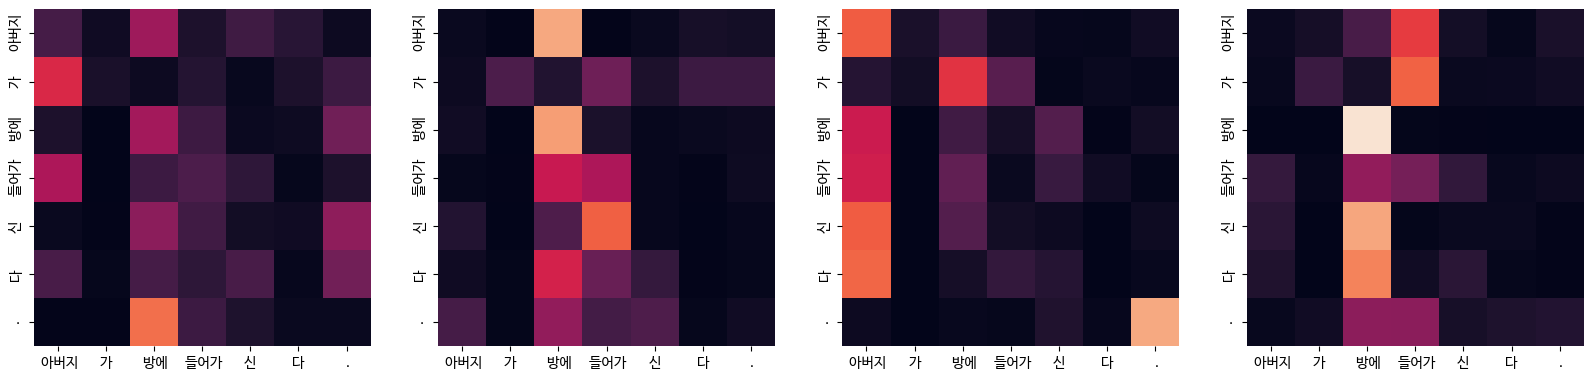

[Encoder Layer(=Self Attention) 2 ]


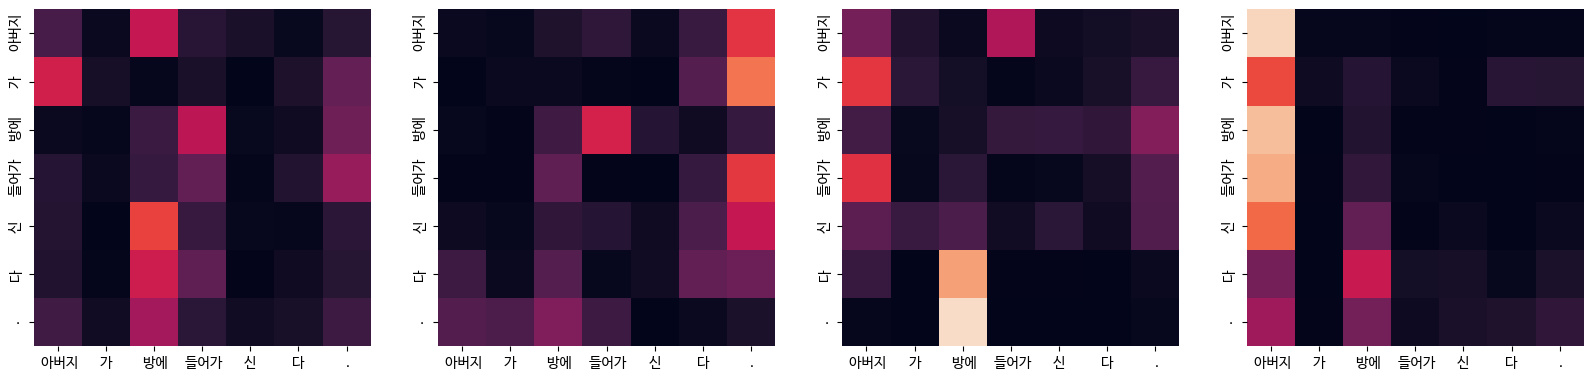

[Decoder Self Layer 1 ]


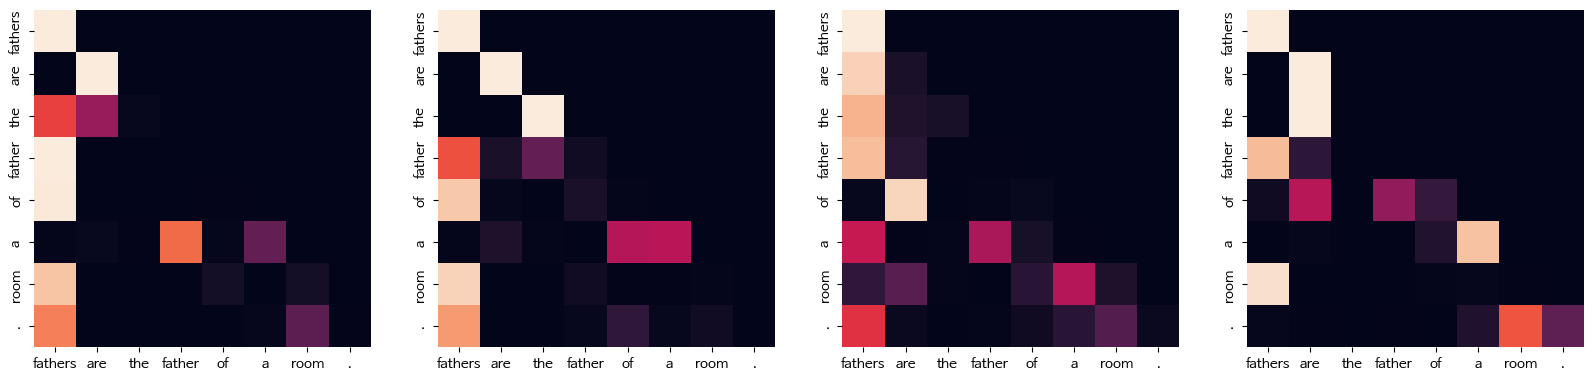

[Decoder Layer(Context Vector By Decoder Input) 1]


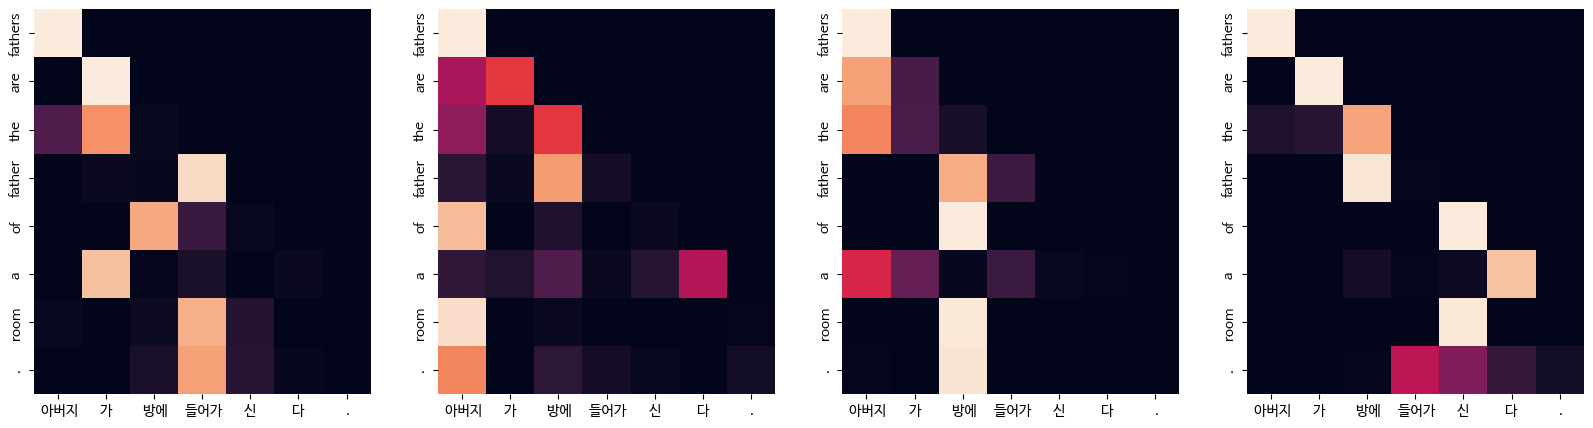

[Decoder Self Layer 2 ]


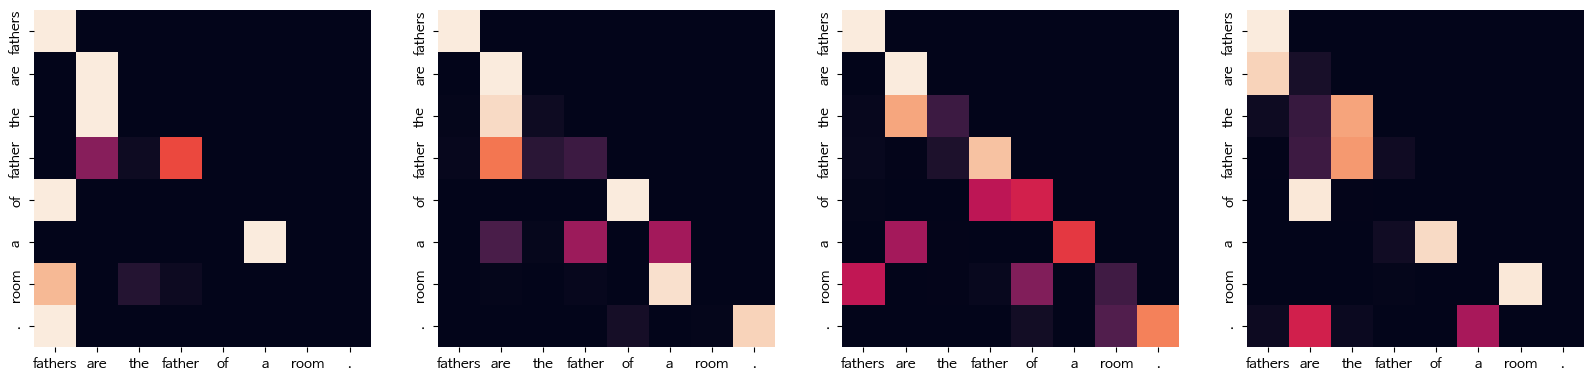

[Decoder Layer(Context Vector By Decoder Input) 2]


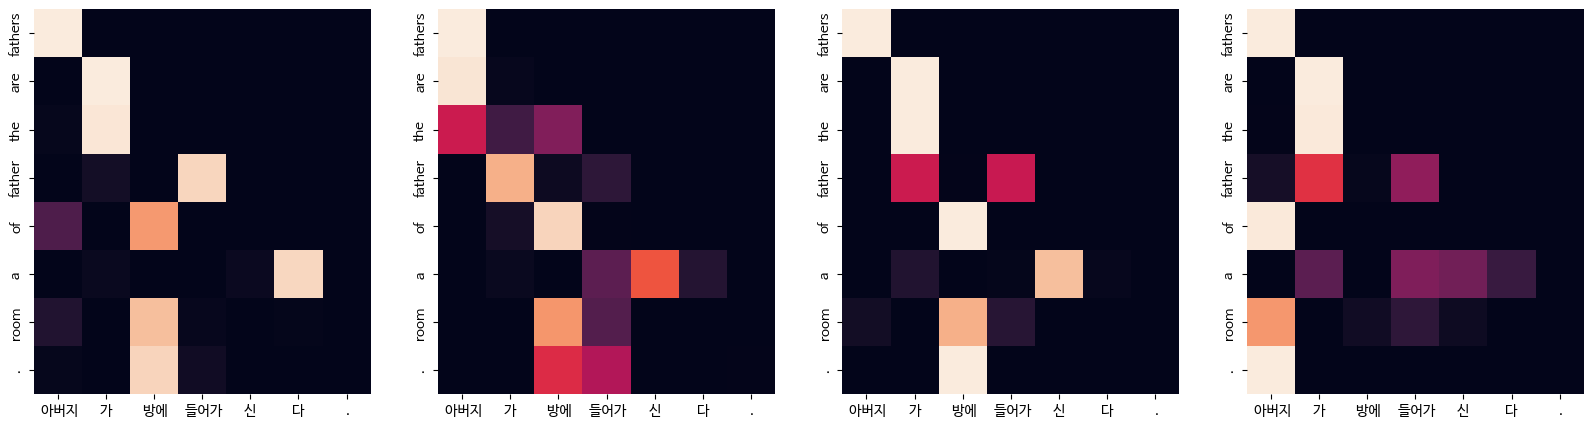

In [43]:
train_model(enc_tensor, dec_tensor,enc_tokenizer, dec_tokenizer)

# Trial + 10 epoch

<ipython-input-40-f80adb630dd9>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

[EPOCH 4]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: the father is a room and father of the home .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i ve never been a patient .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: while there have been a good night periods of flashing customers in the business he ve had been pressing on its job , it has not been informed of it about its owns .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: a m . computers sends you nothing to send you away .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: we re reports tomorrow evening tomorrow evening , we re 7 evening .

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: two weathers are going

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: you really love you . it .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: music was s music and her back clothes .

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: it s a long press man with 

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

[EPOCH 9]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: a father is owned by christmas and family has fathered .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i learned what i do you do you do .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: there s possible news that this is a good day .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: don t have a serious amount of serious serious .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: we re talking to the most tomorrow

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: it is two . . . .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: you ve love love you .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: music s music was paid musicals

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: in a recent recent times it s last you ve kindly starred in you know .

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: i ll travel to you or to the business .

[Encoder Layer(=Sel

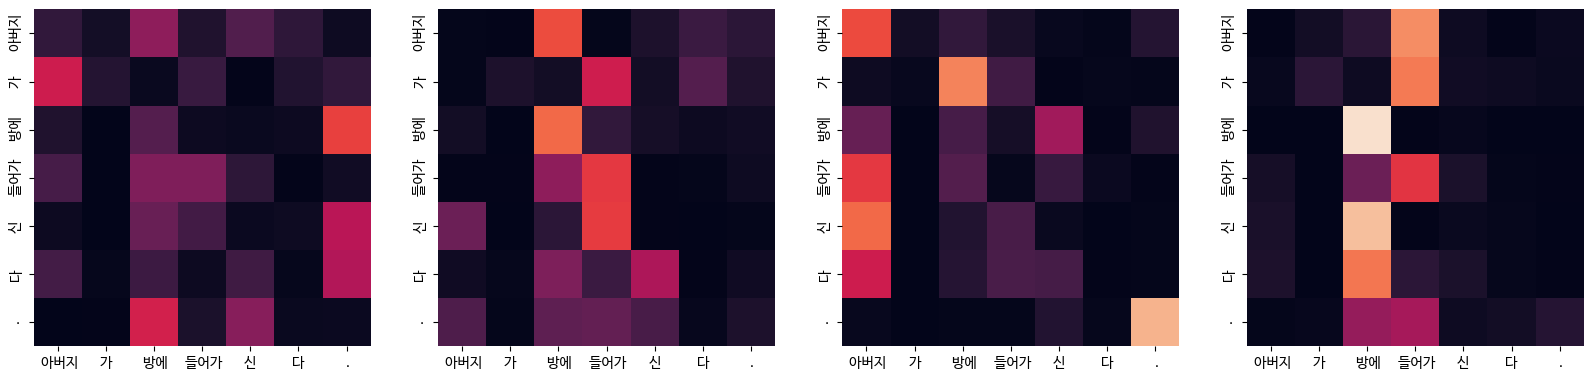

[Encoder Layer(=Self Attention) 2 ]


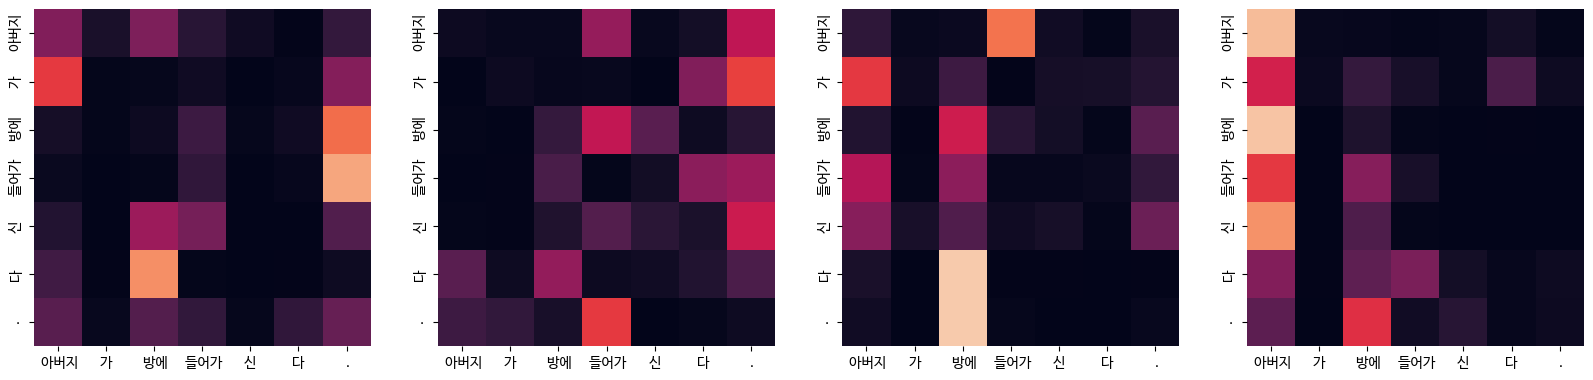

[Decoder Self Layer 1 ]


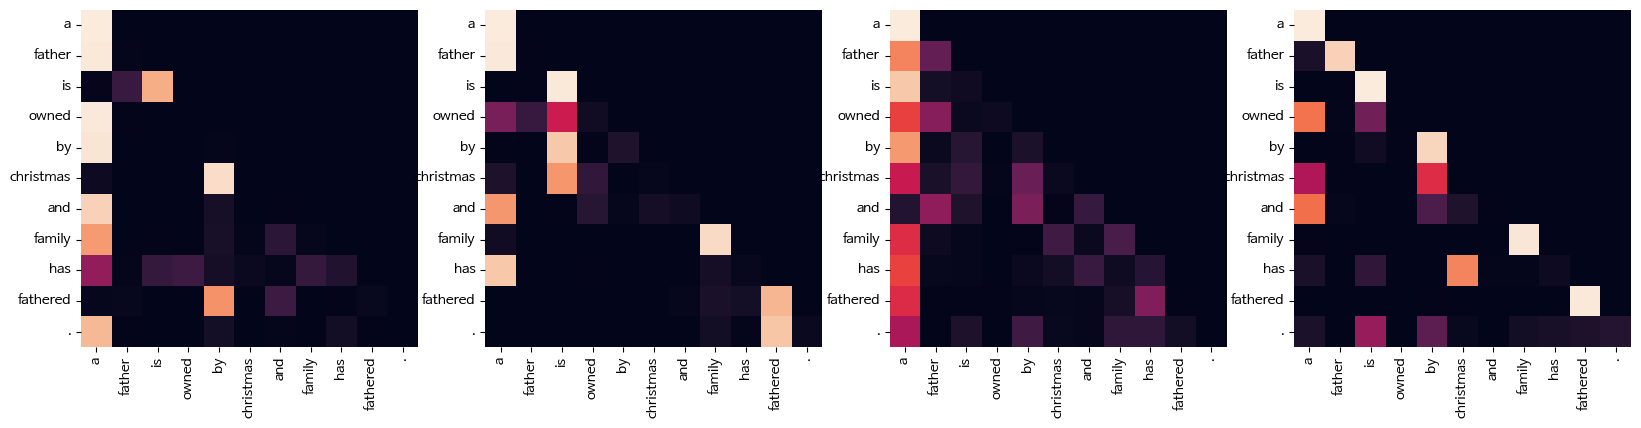

[Decoder Layer(Context Vector By Decoder Input) 1]


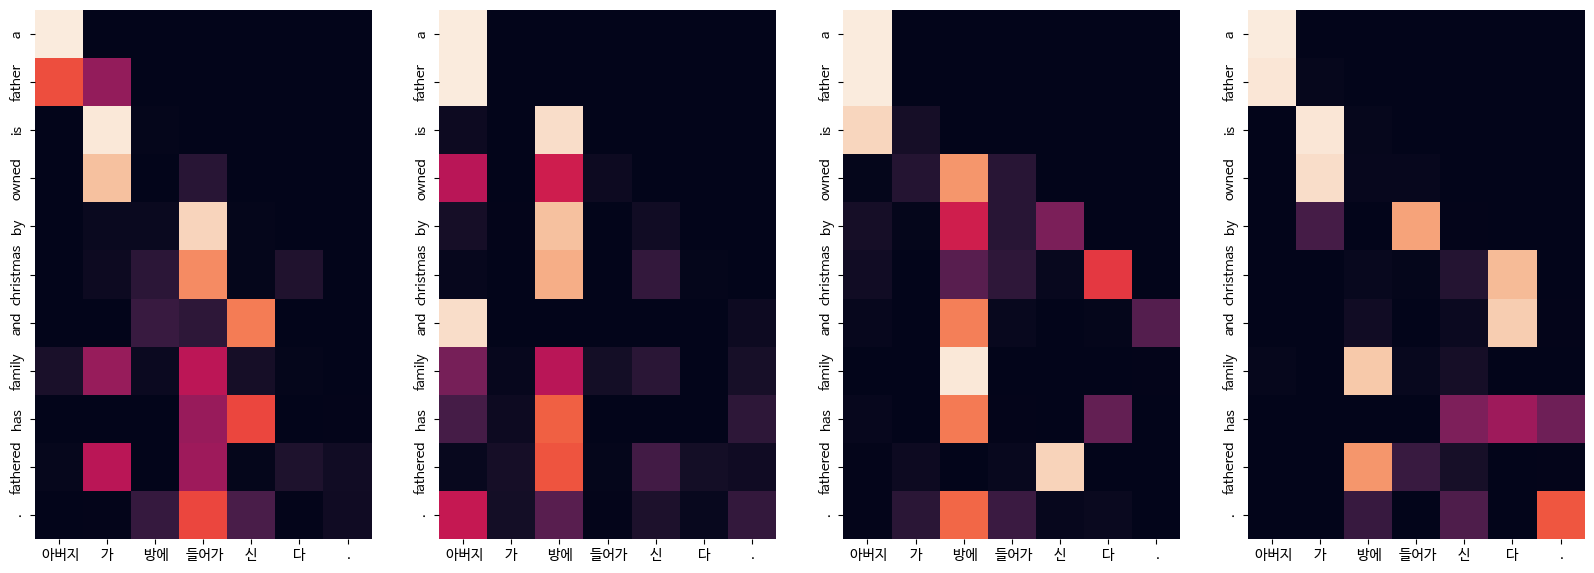

[Decoder Self Layer 2 ]


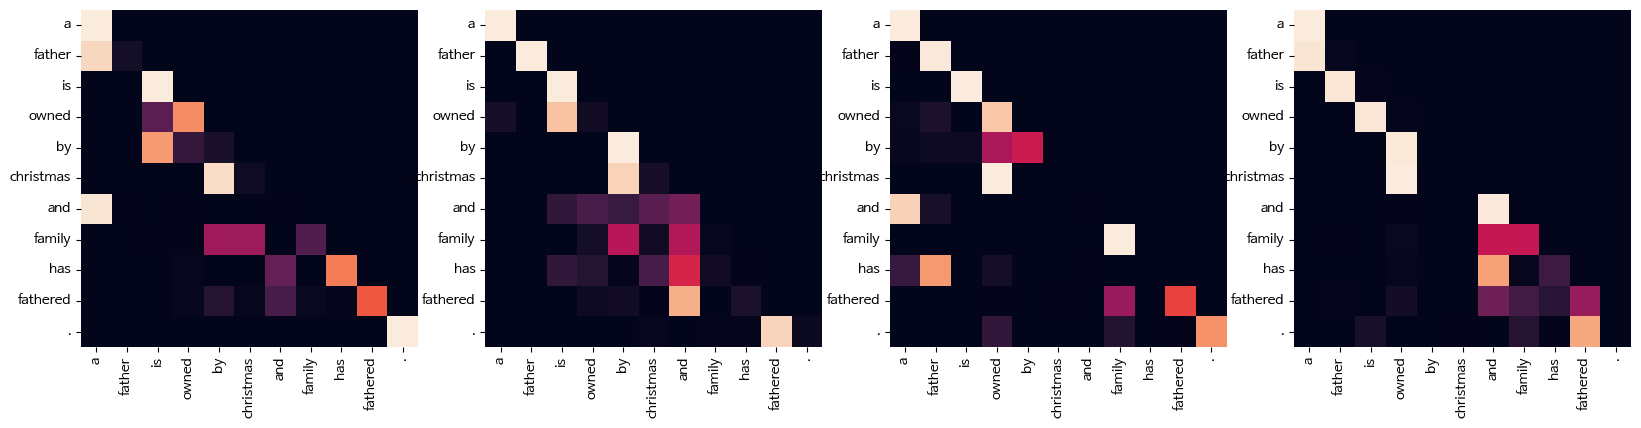

[Decoder Layer(Context Vector By Decoder Input) 2]


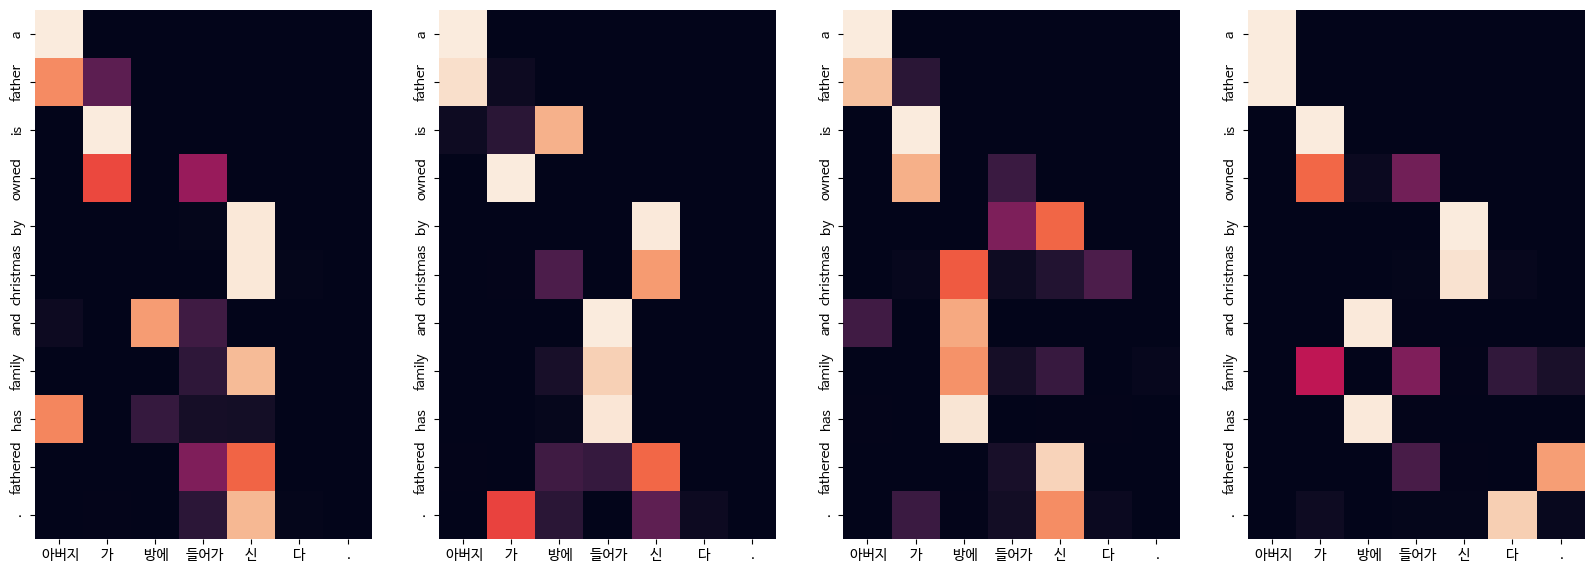

In [44]:
train_model(enc_tensor, dec_tensor,enc_tokenizer, dec_tokenizer)